In [1]:
!pip install transformers==2.11.0 #CHECK maybe remove ==

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 674 kB 4.1 MB/s 
     |████████████████████████████████| 5.6 MB 73.9 MB/s 
     |████████████████████████████████| 1.2 MB 78.0 MB/s 
     |████████████████████████████████| 880 kB 82.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=aeac2606975f7116247a5b4cbd68be882a6c1ff80d25cf204fc2479da2200aa9
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [2]:
import json
import time
import torch
import datetime
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertModel, BertPreTrainedModel
from transformers import AdamW
import matplotlib.pyplot as plt
# CHECK maybe remove some

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/NLP/'

Mounted at /content/drive
/content/drive/My Drive/NLP


In [4]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [5]:
class Bert_QA_Model(nn.Module):

    def __init__(self, freeze = 0):
        super(Bert_QA_Model, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.hidden_size = self.bert.config.hidden_size
        self.start_lin = nn.Linear(self.hidden_size, 1)
        self.end_lin = nn.Linear(self.hidden_size, 1)


        if freeze != 0:
          for param in list(self.bert.embeddings.parameters()):
              param.requires_grad = False
                
          for i in range(1, 1 + freeze):
              for param in list(self.bert.encoder.layer[i].parameters()):
                  param.requires_grad = False


    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):
        
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_states = bert_out[0]
        start_log = self.start_lin(hidden_states).squeeze(-1)
        end_log = self.end_lin(hidden_states).squeeze(-1) 
        start_probs = F.log_softmax(start_log, dim=1)
        end_probs = F.log_softmax(end_log, dim=1)

        return start_probs, end_probs

In [6]:
model1 = Bert_QA_Model()
model2 = Bert_QA_Model(2)
model3 = Bert_QA_Model(4)
model4 = Bert_QA_Model(8)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
def squad_to_lists(file_name, cutsize=False):
    with open(file_name, 'r') as file:
        data = json.load(file)

    que, con, ans, que_id = [], [], [], []

    for i in range(0,len(data['data']), 5):
      for p in range(0, len(data['data'][i]['paragraphs']), 2): 

          context = data['data'][i]['paragraphs'][p]['context']
          for q in range(0, len(data['data'][i]['paragraphs'][p]['qas']), 1): 

              question = data['data'][i]['paragraphs'][p]['qas'][q]['question']
              question_id = data['data'][i]['paragraphs'][p]['qas'][q]["id"]
              temp = data['data'][i]['paragraphs'][p]['qas'][q]['answers']
              answer = temp[0] if temp else {"answer_end": 0, "answer_start": 0}

              if temp:
                answer["answer_end"] = answer["answer_start"] + len(answer["text"])

              con.append(context)
              que.append(question)                    
              ans.append(answer)
              que_id.append(question_id)

    return que, con, ans,  que_id

In [8]:
train_que, train_con, train_ans, _ = squad_to_lists('train-v2.0.json', True)
dev_que, dev_con, dev_ans, dev_que_id = squad_to_lists('dev-v2.0.json',True)

In [9]:
print(len(train_que))

12941


In [10]:
zipped_train = list(zip(train_con, train_que))
zipped_dev = list(zip(dev_con, dev_que))

train_encod = tokenizer.batch_encode_plus(zipped_train, max_length=tokenizer.model_max_length, pad_to_max_length=True, return_token_type_ids=True)

dev_encod = tokenizer.batch_encode_plus(zipped_dev, max_length=tokenizer.model_max_length, pad_to_max_length=True, return_token_type_ids=True)

In [11]:
def add_token_positions(tokenizer, encodings, answers):
    start_pos = []
    end_pos = []
    
    for i in range(len(answers)):

        start_pos.append(encodings.char_to_token(i, answers[i]['answer_start']) if answers[i]['answer_end'] != 0 else 0)
        end_pos.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1) if answers[i]['answer_end'] != 0 else 0)    
        
        start_pos[-1] = tokenizer.model_max_length if start_pos[-1] is None else start_pos[-1]
        end_pos[-1] = tokenizer.model_max_length if end_pos[-1] is None else end_pos[-1]
    
    encodings.update({'start_positions': start_pos, 'end_positions': end_pos})


In [12]:
add_token_positions(tokenizer, train_encod, train_ans)
add_token_positions(tokenizer,dev_encod, dev_ans)

In [13]:
class Squad_to_dataset(torch.utils.data.Dataset):
    
  def __init__(self, encodings):
    self.encodings = encodings
    self.length = len(self.encodings.input_ids)

  def __getitem__(self, idx):
    res = {}
    for key, val in self.encodings.items():
      res[key] = torch.tensor(val[idx])

    return res

  def __len__(self):
    return self.length

In [14]:
train_loader = DataLoader(Squad_to_dataset(train_encod), batch_size=8, shuffle=True)

dev_loader = DataLoader(Squad_to_dataset(dev_encod), batch_size=8, shuffle=False)

In [15]:
def evaluate(model, loader, ignored_index):
    answers = []
    total_dev_loss = 0

    with torch.no_grad():

        for b in loader:

            input_ids = b['input_ids'].to(DEVICE)
            attention_mask = b['attention_mask'].to(DEVICE)
            token_type_ids = b['token_type_ids'].to(DEVICE)
            start_positions = b['start_positions'].to(DEVICE)
            end_positions = b['end_positions'].to(DEVICE)


            start_o, end_o = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids) 

            start_loss = F.nll_loss(start_o, start_positions, ignore_index=ignored_index)
            end_loss = F.nll_loss(end_o, end_positions, ignore_index=ignored_index)

            total_loss = (start_loss + end_loss) / 2
            total_dev_loss += total_loss.item()
            start_pred = torch.argmax(start_o.detach().cpu(), dim=1).tolist()
            end_pred = torch.argmax(end_o.detach().cpu(), dim=1).tolist()
            input_ids = input_ids.detach().cpu().tolist()
            cls_t = [tokenizer.cls_token_id]

            for current_input_ids, start_p, end_p in zip(input_ids, start_pred, end_pred):

                ans_tokens = current_input_ids[start_p: end_p + 1]

                if cls_t != ans_tokens and cls_t[0] in ans_tokens:
                    del ans_tokens[0]
                
                if cls_t == ans_tokens:
                    answers.append('')
                else:
                    answers.append(tokenizer.convert_tokens_to_string(ans_tokens))

    return total_dev_loss / len(loader), answers

In [16]:
def produce_predictions_file(questions_ids, predictions, epoch):
    
    preds = {key: val for key, val in zip(questions_ids, predictions)}

    if epoch == 1:
        with open('./preds_model1_epoch_1.json', 'w') as outfile:
            json.dump(preds, outfile)

        abc = !python3 evaluate-v2.0-40.py ./dev-v2.0.json ./preds_model1_epoch_1.json
    else:
        if epoch == 2:
            with open('./preds_model1_epoch_2.json', 'w') as outfile:
                json.dump(preds, outfile)

            abc = !python3 evaluate-v2.0-40.py ./dev-v2.0.json ./preds_model1_epoch_2.json
        else:
            if epoch == 3:
                with open('./preds_model1_epoch_3.json', 'w') as outfile:
                    json.dump(preds, outfile)

                abc = !python3 evaluate-v2.0-40.py ./dev-v2.0.json ./preds_model1_epoch_3.json
            else:
                with open('./preds_model1_epoch_0.json', 'w') as outfile:
                    json.dump(preds, outfile)

                abc = !python3 evaluate-v2.0-40.py ./dev-v2.0.json ./preds_model1_epoch_0.json
      
    abc = eval(''.join(abc))

    for key, val in abc.items():
      abc[key] = np.round(val, 2)
    
    return (epoch, abc)

In [17]:
if torch.cuda.is_available():
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()

In [18]:
EPOCHS = 3 #CHECK maybe change

MODEL_FILE = "./model1_File"

opti1 = AdamW(model1.parameters(), lr=2e-5)
opti2 = AdamW(model2.parameters(), lr=2e-5)
opti3 = AdamW(model3.parameters(), lr=2e-5)
opti4 = AdamW(model4.parameters(), lr=2e-5)

In [19]:
def train(model, train_loader, dev_loader, optimizer, epochs, ignored_index):

    train_epochs_loss, dev_epochs_loss = [], []
    
    lr = optimizer.param_groups[0]['lr']
    initial_dev_loss, preds = evaluate(model, dev_loader, ignored_index)
    dev_epochs_loss.append(initial_dev_loss)
    dicts=[]
    
    dicts.append(produce_predictions_file(dev_que_id, preds, 0))
    print(dicts[-1])

    for epoch in range(0, epochs):
        print(epoch)
        model.train()
        total_train_loss = 0.0
        sum_loss = 0.0

        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            token_type_ids = batch['token_type_ids'].to(DEVICE)
            start_positions = batch['start_positions'].to(DEVICE)
            end_positions = batch['end_positions'].to(DEVICE)


            start_o, end_o = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

            start_loss = F.nll_loss(start_o, start_positions, ignore_index=ignored_index)
            end_loss = F.nll_loss(end_o, end_positions, ignore_index=ignored_index)
            total_loss = (start_loss + end_loss) / 2
            
            total_train_loss += total_loss.item()
            sum_loss += total_loss.item()

            total_loss.backward()
            optimizer.step()
        
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, MODEL_FILE + "-epoch" + str(epoch + 1))
        
        avg_train_loss = total_train_loss / len(train_loader)            
        train_epochs_loss.append(avg_train_loss)

        model.eval()

        avg_dev_loss, preds = evaluate(model, dev_loader, ignored_index)
        dev_epochs_loss.append(avg_dev_loss)
        
        dicts.append(produce_predictions_file(dev_que_id, preds, epoch + 1))
        print(dicts[-1])

    return dicts, train_epochs_loss, dev_epochs_loss


In [20]:
dicts1, train_epochs_loss1, dev_epochs_loss1 = train(model1, train_loader, dev_loader, opti1, epochs=EPOCHS, ignored_index=tokenizer.model_max_length)

(0, {'exact': 21.68, 'f1': 23.13, 'total': 1213, 'HasAns_exact': 0.0, 'HasAns_f1': 3.02, 'HasAns_total': 579, 'NoAns_exact': 41.48, 'NoAns_f1': 41.48, 'NoAns_total': 634})
0
(1, {'exact': 53.67, 'f1': 56.14, 'total': 1213, 'HasAns_exact': 28.15, 'HasAns_f1': 33.32, 'HasAns_total': 579, 'NoAns_exact': 76.97, 'NoAns_f1': 76.97, 'NoAns_total': 634})
1
(2, {'exact': 58.12, 'f1': 60.61, 'total': 1213, 'HasAns_exact': 40.41, 'HasAns_f1': 45.62, 'HasAns_total': 579, 'NoAns_exact': 74.29, 'NoAns_f1': 74.29, 'NoAns_total': 634})
2
(3, {'exact': 57.05, 'f1': 61.43, 'total': 1213, 'HasAns_exact': 55.96, 'HasAns_f1': 65.13, 'HasAns_total': 579, 'NoAns_exact': 58.04, 'NoAns_f1': 58.04, 'NoAns_total': 634})


In [21]:
dicts2, train_epochs_loss2, dev_epochs_loss2 = train(model2, train_loader, dev_loader, opti2, epochs=EPOCHS, ignored_index=tokenizer.model_max_length)

(0, {'exact': 22.18, 'f1': 23.25, 'total': 1213, 'HasAns_exact': 0.0, 'HasAns_f1': 2.24, 'HasAns_total': 579, 'NoAns_exact': 42.43, 'NoAns_f1': 42.43, 'NoAns_total': 634})
0
(1, {'exact': 54.49, 'f1': 57.62, 'total': 1213, 'HasAns_exact': 35.41, 'HasAns_f1': 41.96, 'HasAns_total': 579, 'NoAns_exact': 71.92, 'NoAns_f1': 71.92, 'NoAns_total': 634})
1
(2, {'exact': 59.44, 'f1': 62.8, 'total': 1213, 'HasAns_exact': 51.47, 'HasAns_f1': 58.5, 'HasAns_total': 579, 'NoAns_exact': 66.72, 'NoAns_f1': 66.72, 'NoAns_total': 634})
2
(3, {'exact': 57.87, 'f1': 61.78, 'total': 1213, 'HasAns_exact': 56.65, 'HasAns_f1': 64.84, 'HasAns_total': 579, 'NoAns_exact': 58.99, 'NoAns_f1': 58.99, 'NoAns_total': 634})


In [22]:
dicts3, train_epochs_loss3, dev_epochs_loss3 = train(model3, train_loader, dev_loader, opti3, epochs=EPOCHS, ignored_index=tokenizer.model_max_length)

(0, {'exact': 21.68, 'f1': 23.47, 'total': 1213, 'HasAns_exact': 0.0, 'HasAns_f1': 3.74, 'HasAns_total': 579, 'NoAns_exact': 41.48, 'NoAns_f1': 41.48, 'NoAns_total': 634})
0
(1, {'exact': 48.23, 'f1': 52.1, 'total': 1213, 'HasAns_exact': 50.78, 'HasAns_f1': 58.89, 'HasAns_total': 579, 'NoAns_exact': 45.9, 'NoAns_f1': 45.9, 'NoAns_total': 634})
1
(2, {'exact': 56.64, 'f1': 59.23, 'total': 1213, 'HasAns_exact': 40.07, 'HasAns_f1': 45.5, 'HasAns_total': 579, 'NoAns_exact': 71.77, 'NoAns_f1': 71.77, 'NoAns_total': 634})
2
(3, {'exact': 55.48, 'f1': 58.86, 'total': 1213, 'HasAns_exact': 48.19, 'HasAns_f1': 55.25, 'HasAns_total': 579, 'NoAns_exact': 62.15, 'NoAns_f1': 62.15, 'NoAns_total': 634})


In [23]:
dicts4, train_epochs_loss4, dev_epochs_loss4 = train(model4, train_loader, dev_loader, opti4, epochs=EPOCHS, ignored_index=tokenizer.model_max_length)

(0, {'exact': 20.12, 'f1': 21.71, 'total': 1213, 'HasAns_exact': 0.0, 'HasAns_f1': 3.34, 'HasAns_total': 579, 'NoAns_exact': 38.49, 'NoAns_f1': 38.49, 'NoAns_total': 634})
0
(1, {'exact': 51.28, 'f1': 52.81, 'total': 1213, 'HasAns_exact': 14.51, 'HasAns_f1': 17.71, 'HasAns_total': 579, 'NoAns_exact': 84.86, 'NoAns_f1': 84.86, 'NoAns_total': 634})
1
(2, {'exact': 50.54, 'f1': 54.66, 'total': 1213, 'HasAns_exact': 33.85, 'HasAns_f1': 42.5, 'HasAns_total': 579, 'NoAns_exact': 65.77, 'NoAns_f1': 65.77, 'NoAns_total': 634})
2
(3, {'exact': 52.51, 'f1': 55.53, 'total': 1213, 'HasAns_exact': 29.36, 'HasAns_f1': 35.67, 'HasAns_total': 579, 'NoAns_exact': 73.66, 'NoAns_f1': 73.66, 'NoAns_total': 634})


In [24]:
def draw_graph(dicts, title):
  y_max = int(max([x[1][y] for (_ ,t, y) in dicts for x in t]))
  y_min = int(min([x[1][y] for (_ ,t, y) in dicts for x in t]))

  for line in dicts:
    ep = list(range(1,len(line[1]) + 1))
    by_key = [x[1][line[2]] for x in line[1]]
    plt.plot(ep, by_key, "o:", label=line[0])
    
    for i, txt in zip(ep, by_key):
      plt.annotate(str(np.round(txt,2)), (i, txt + 0.2))
  
  plt.yticks(list(range(y_min - 5, y_max + 10, 5)))
  plt.ylabel("score")
  plt.xlabel("epoch")
  plt.title(title)
  plt.xticks(ep)

  plt.legend()
  plt.show()

In [25]:
def draw_graph_train_loss(ls, title):
  y_max = int(max(ls))
  y_min = int(min(ls))
  ep = list(range(1,len(ls) + 1))
  plt.plot(ep, ls)
  
  for i, txt in zip(ep, ls):
    plt.annotate(str(np.round(txt,2)), (i, txt + 0.2))
  
  plt.yticks(list(range(y_min - 1, y_max + 4, 2)))
  plt.ylabel("score")
  plt.xlabel("epoch")
  plt.title(title)
  plt.xticks(ep)
  
  # plt.legend()
  plt.show()

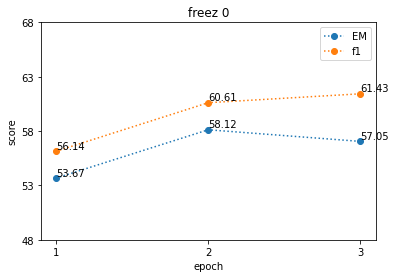

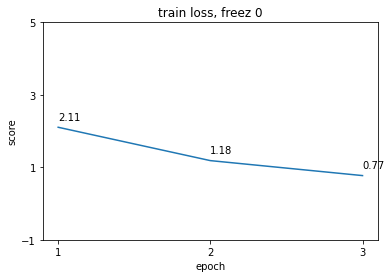

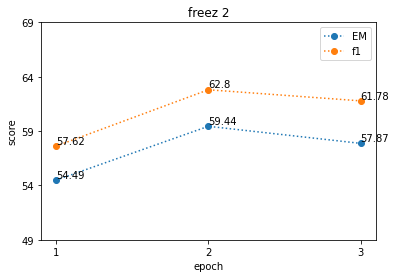

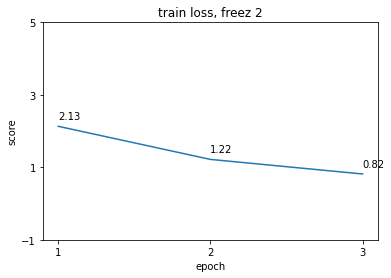

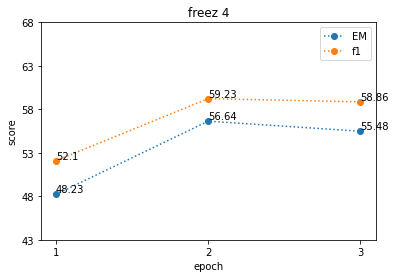

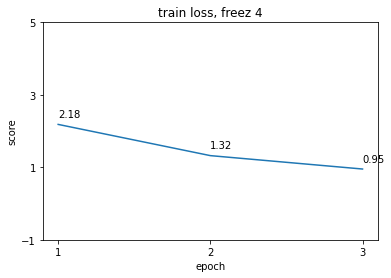

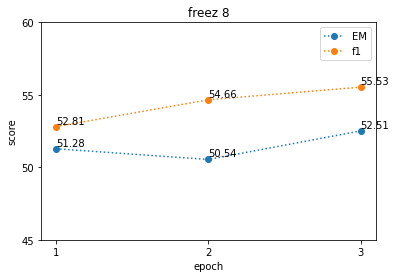

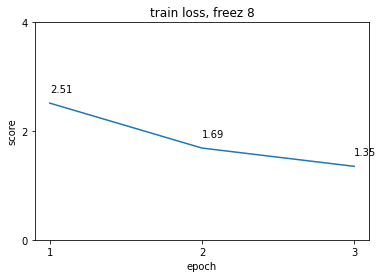

In [27]:
all_dicts = [dicts1[1:], dicts2[1:], dicts3[1:], dicts4[1:]]
train_loss = [train_epochs_loss1, train_epochs_loss2, train_epochs_loss3, train_epochs_loss4]
for i, freez in enumerate([0,2,4,8]):
  graph = [("EM",all_dicts[i],"exact"), ("f1",all_dicts[i],"f1")]
  draw_graph(graph, "freez " + str(freez))
  print()
  draw_graph_train_loss(train_loss[i], "train loss, freez " + str(freez))
  print()
  print()
  print()